In [5]:
import scanpy, scprep, phate
import numpy as np
from sklearn.decomposition import PCA

In [2]:
scanpy.set_figure_params(dpi=200, facecolor='white')
cmap = ['#ea7e77', '#be9b35', '#6fb136', '#56bc99', '#52b3e8', '#9e8bf8', '#e96dcd']

In [3]:
sdata = scanpy.read_h5ad('/data/lab/datasets/microglia/inj_vs_wt.h5ad')

<AxesSubplot:title={'center':'Merged data\nPreviously annotated clusters'}, xlabel='PHATE1', ylabel='PHATE2'>

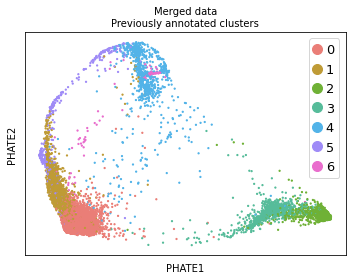

In [4]:
scprep.plot.scatter2d(sdata.obsm['X_phate'], c=sdata.obs['cluster_labels'].astype(int), figsize=(5,4), cmap=cmap,
                      ticks=None, label_prefix='PHATE', dpi=200, title='Merged data\nPreviously annotated clusters')

## Subset to clusters on left trajectory to run TrajectoryNet separately

In [5]:
sdata_trajectory = sdata[sdata.obs['cluster_labels'].isin(['0','1','5','4'])]

/home/aarthivenkat/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


## Rename clusters 0, 1, 5, 4 to timepoints 0, 1, 2, 3 respectively for TrajectoryNet

In [6]:
timepoints = {'0':0, '1':1, '5':2, '4':3}
sdata_trajectory.obs['timepoints'] = [timepoints[x] for x in sdata_trajectory.obs['cluster_labels']]

Trying to set attribute `.obs` of view, copying.


## Run PCA

In [7]:
pc_op = PCA(random_state=42, n_components=100) # TrajectoryNet automatically clips to 10 components maximum
data_pc = pc_op.fit_transform(sdata_trajectory.to_df())

## Standardize data_pc for TrajectoryNet

In [8]:
data_pc = data_pc / np.std(data_pc[:, 0])

## Visualize data_pc

<AxesSubplot:title={'center':'Timepoints for TrajectoryNet'}>

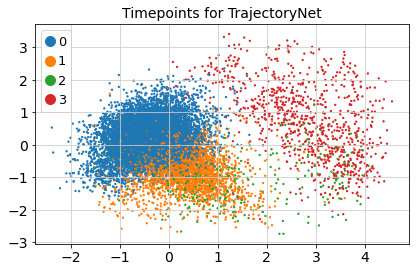

In [9]:
scprep.plot.scatter2d(data_pc, c=sdata_trajectory.obs['timepoints'], ticks=True, title='Timepoints for TrajectoryNet')

## Run PHATE 

In [10]:
phate_op = phate.PHATE(random_state=42, knn=10)
data_phate = phate_op.fit_transform(data_pc)

Calculating PHATE...
  Running PHATE on 14167 observations and 100 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 24.41 seconds.
    Calculating affinities...
    Calculated affinities in 16.07 seconds.
  Calculated graph and diffusion operator in 40.53 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 2.83 seconds.
    Calculating KMeans...
    Calculated KMeans in 4.57 seconds.
  Calculated landmark operator in 8.96 seconds.
  Calculating optimal t...
    Automatically selected t = 20
  Calculated optimal t in 2.48 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.43 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.27 seconds.
Calculated PHATE in 56.69 seconds.


## Standardize data_phate for TrajectoryNet

In [11]:
data_phate = data_phate / np.std(data_phate[:, 0])

## Visualize data_phate

<AxesSubplot:title={'center':'Timepoints for TrajectoryNet'}>

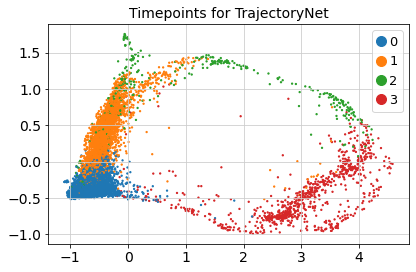

In [12]:
scprep.plot.scatter2d(data_phate, c=sdata_trajectory.obs['timepoints'], ticks=True, title='Timepoints for TrajectoryNet')

# TrajectoryNet requires npz file with:
### An embedding matrix titled [embedding_name] (Cells x Dimensions)
### A sample labels array titled sample_labels (Cells)

In [13]:
np.savez('microglia_for_trajectorynet.npz', pca=data_pc, phate=data_phate, 
        sample_labels=np.array(sdata_trajectory.obs['timepoints']))

In [6]:
# Load
data = np.load('../data/microglia_for_trajectorynet.npz')

In [9]:
data_pca = data['pca']
print(data_pca.shape)

(14167, 100)


In [11]:
sample_labels = data['sample_labels']
print(sample_labels)

[3 1 1 ... 0 0 0]


In [12]:
!python -m TrajectoryNet.main --dataset '../data/microglia_for_trajectorynet.npz' --embedding_name 'pca'

True
/Users/danqiliao/opt/miniconda3/envs/cos429/lib/python3.7/site-packages/TrajectoryNet/main.py
""" main.py

Learns ODE from scrna data

"""
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time

import torch
import torch.nn.functional as F
import torch.optim as optim

from TrajectoryNet.lib.growth_net import GrowthNet
from TrajectoryNet.lib import utils
from TrajectoryNet.lib.visualize_flow import visualize_transform
from TrajectoryNet.lib.viz_scrna import (
    save_trajectory,
    trajectory_to_video,
    save_vectors,
)
from TrajectoryNet.lib.viz_scrna import save_trajectory_density


# from train_misc import standard_normal_logprob
from TrajectoryNet.train_misc import (
    set_cnf_options,
    count_nfe,
    count_parameters,
    count_total_time,
    add_spectral_norm,
    spectral_norm_power_iteration,
    create_regularization_fns,
    get_regularization,
    append_regularization_to_log,
    build_model_tabular,
)

from TrajectoryNet im

Iter 0001 | Time 13.6323(13.6323) | Loss 14.369546(14.369546) | NFE Forward 14(14.0) | NFE Backward 102(102.0)
Iter 0002 | Time 11.9713(13.5161) | Loss 14.188717(14.356888) | NFE Forward 14(14.0) | NFE Backward 102(102.0)
Iter 0003 | Time 12.3738(13.4361) | Loss 13.930426(14.327036) | NFE Forward 14(14.0) | NFE Backward 102(102.0)
Iter 0004 | Time 12.7204(13.3860) | Loss 13.773233(14.288269) | NFE Forward 14(14.0) | NFE Backward 102(102.0)
Iter 0005 | Time 12.0593(13.2931) | Loss 13.662763(14.244484) | NFE Forward 14(14.0) | NFE Backward 102(102.0)
Iter 0006 | Time 11.5582(13.1717) | Loss 13.442257(14.188328) | NFE Forward 14(14.0) | NFE Backward 102(102.0)
Iter 0007 | Time 12.1920(13.1031) | Loss 13.315804(14.127251) | NFE Forward 14(14.0) | NFE Backward 102(102.0)
Iter 0008 | Time 13.0987(13.1028) | Loss 13.157821(14.059391) | NFE Forward 14(14.0) | NFE Backward 96(101.6)
Iter 0009 | Time 11.1695(12.9675) | Loss 12.973821(13.983401) | NFE Forward 14(14.0) | NFE Backward 96(101.2)
Ite

Iter 0076 | Time 16.0265(13.3941) | Loss 10.816130(11.021043) | NFE Forward 20(17.2) | NFE Backward 102(100.3)
Iter 0077 | Time 13.6804(13.4142) | Loss 10.799282(11.005520) | NFE Forward 20(17.4) | NFE Backward 102(100.4)
Iter 0078 | Time 14.9887(13.5244) | Loss 10.766456(10.988786) | NFE Forward 20(17.6) | NFE Backward 102(100.5)
Iter 0079 | Time 13.3247(13.5104) | Loss 10.726111(10.970398) | NFE Forward 20(17.8) | NFE Backward 102(100.6)
Iter 0080 | Time 13.4085(13.5033) | Loss 10.719964(10.952868) | NFE Forward 20(17.9) | NFE Backward 102(100.7)
Iter 0081 | Time 12.8289(13.4561) | Loss 10.679873(10.933758) | NFE Forward 20(18.1) | NFE Backward 102(100.8)
Iter 0082 | Time 17.1549(13.7150) | Loss 10.717468(10.918618) | NFE Forward 20(18.2) | NFE Backward 102(100.9)
Iter 0083 | Time 13.7561(13.7179) | Loss 10.650587(10.899856) | NFE Forward 20(18.3) | NFE Backward 102(101.0)
Iter 0084 | Time 13.8344(13.7260) | Loss 10.634695(10.881295) | NFE Forward 20(18.5) | NFE Backward 102(101.1)
I

Iter 0150 | Time 12.2386(12.4038) | Loss 8.596072(8.930280) | NFE Forward 20(20.0) | NFE Backward 102(101.2)
Iter 0151 | Time 11.7181(12.3558) | Loss 8.572763(8.905254) | NFE Forward 20(20.0) | NFE Backward 96(100.9)
Iter 0152 | Time 12.2582(12.3490) | Loss 8.511086(8.877662) | NFE Forward 20(20.0) | NFE Backward 102(101.0)
Iter 0153 | Time 11.8205(12.3120) | Loss 8.561745(8.855548) | NFE Forward 20(20.0) | NFE Backward 96(100.6)
Iter 0154 | Time 12.5250(12.3269) | Loss 8.575886(8.835972) | NFE Forward 20(20.0) | NFE Backward 102(100.7)
Iter 0155 | Time 12.6540(12.3498) | Loss 8.511752(8.813276) | NFE Forward 20(20.0) | NFE Backward 102(100.8)
Iter 0156 | Time 12.3339(12.3487) | Loss 8.411339(8.785141) | NFE Forward 20(20.0) | NFE Backward 102(100.9)
Iter 0157 | Time 11.9213(12.3187) | Loss 8.439201(8.760925) | NFE Forward 20(20.0) | NFE Backward 96(100.5)
Iter 0158 | Time 12.2915(12.3168) | Loss 8.425726(8.737461) | NFE Forward 20(20.0) | NFE Backward 102(100.6)
Iter 0159 | Time 12.28

Iter 0226 | Time 14.3104(16.9692) | Loss 7.418044(7.537995) | NFE Forward 20(20.0) | NFE Backward 108(103.5)
Iter 0227 | Time 14.6766(16.8087) | Loss 7.311466(7.522138) | NFE Forward 20(20.0) | NFE Backward 108(103.8)
Iter 0228 | Time 14.6797(16.6597) | Loss 7.350780(7.510143) | NFE Forward 20(20.0) | NFE Backward 108(104.1)
Iter 0229 | Time 15.0819(16.5492) | Loss 7.329841(7.497522) | NFE Forward 20(20.0) | NFE Backward 108(104.4)
Iter 0230 | Time 15.0721(16.4458) | Loss 7.292743(7.483187) | NFE Forward 20(20.0) | NFE Backward 108(104.6)
Iter 0231 | Time 15.4839(16.3785) | Loss 7.305525(7.470751) | NFE Forward 20(20.0) | NFE Backward 108(104.9)
Iter 0232 | Time 15.7929(16.3375) | Loss 7.295724(7.458499) | NFE Forward 20(20.0) | NFE Backward 108(105.1)
Iter 0233 | Time 15.9226(16.3085) | Loss 7.300668(7.447451) | NFE Forward 20(20.0) | NFE Backward 108(105.3)
Iter 0234 | Time 15.4164(16.2460) | Loss 7.235011(7.432580) | NFE Forward 20(20.0) | NFE Backward 108(105.5)
Iter 0235 | Time 16

Iter 0301 | Time 15.5141(56.0466) | Loss 6.696195(6.806250) | NFE Forward 26(25.5) | NFE Backward 108(106.9)
Iter 0302 | Time 15.2857(53.1934) | Loss 6.720087(6.800219) | NFE Forward 26(25.5) | NFE Backward 108(106.9)
Iter 0303 | Time 15.6867(50.5679) | Loss 6.578264(6.784682) | NFE Forward 26(25.6) | NFE Backward 108(107.0)
Iter 0304 | Time 14.4614(48.0404) | Loss 6.638182(6.774427) | NFE Forward 26(25.6) | NFE Backward 108(107.1)
Iter 0305 | Time 16.8368(45.8562) | Loss 6.701332(6.769310) | NFE Forward 26(25.6) | NFE Backward 108(107.1)
Iter 0306 | Time 14.6765(43.6736) | Loss 6.765856(6.769069) | NFE Forward 26(25.7) | NFE Backward 108(107.2)
Iter 0307 | Time 14.5200(41.6328) | Loss 6.607048(6.757727) | NFE Forward 26(25.7) | NFE Backward 108(107.3)
Iter 0308 | Time 14.7712(39.7525) | Loss 6.656904(6.750670) | NFE Forward 26(25.7) | NFE Backward 108(107.3)
Iter 0309 | Time 15.1210(38.0283) | Loss 6.609651(6.740798) | NFE Forward 26(25.7) | NFE Backward 108(107.4)
Iter 0310 | Time 16

Iter 0377 | Time 15.2690(15.2903) | Loss 6.191829(6.274101) | NFE Forward 26(26.0) | NFE Backward 102(106.2)
Iter 0378 | Time 14.0680(15.2047) | Loss 6.255427(6.272794) | NFE Forward 26(26.0) | NFE Backward 102(105.9)
Iter 0379 | Time 13.7208(15.1008) | Loss 6.131402(6.262896) | NFE Forward 26(26.0) | NFE Backward 102(105.6)
Iter 0380 | Time 13.6767(15.0012) | Loss 6.142865(6.254494) | NFE Forward 26(26.0) | NFE Backward 102(105.4)
Iter 0381 | Time 13.6949(14.9097) | Loss 6.169320(6.248532) | NFE Forward 26(26.0) | NFE Backward 102(105.1)
Iter 0382 | Time 13.9959(14.8457) | Loss 6.089381(6.237391) | NFE Forward 26(26.0) | NFE Backward 102(104.9)
Iter 0383 | Time 13.8825(14.7783) | Loss 6.133132(6.230093) | NFE Forward 26(26.0) | NFE Backward 102(104.7)
Iter 0384 | Time 14.4187(14.7532) | Loss 6.144351(6.224091) | NFE Forward 26(26.0) | NFE Backward 102(104.5)
Iter 0385 | Time 13.9755(14.6987) | Loss 6.132202(6.217659) | NFE Forward 26(26.0) | NFE Backward 102(104.3)
Iter 0386 | Time 13

Iter 0452 | Time 16.0572(16.1685) | Loss 5.861385(5.919933) | NFE Forward 26(26.0) | NFE Backward 120(117.6)
Iter 0453 | Time 15.3561(16.1117) | Loss 5.848068(5.914903) | NFE Forward 26(26.0) | NFE Backward 114(117.3)
Iter 0454 | Time 16.0252(16.1056) | Loss 5.902711(5.914049) | NFE Forward 26(26.0) | NFE Backward 120(117.5)
Iter 0455 | Time 16.0489(16.1016) | Loss 5.868853(5.910886) | NFE Forward 26(26.0) | NFE Backward 120(117.7)
Iter 0456 | Time 16.1347(16.1040) | Loss 5.774162(5.901315) | NFE Forward 26(26.0) | NFE Backward 120(117.8)
Iter 0457 | Time 16.2068(16.1112) | Loss 5.897337(5.901036) | NFE Forward 26(26.0) | NFE Backward 120(118.0)
Iter 0458 | Time 15.8743(16.0946) | Loss 5.792807(5.893460) | NFE Forward 26(26.0) | NFE Backward 114(117.7)
Iter 0459 | Time 16.1510(16.0985) | Loss 5.835553(5.889407) | NFE Forward 26(26.0) | NFE Backward 120(117.9)
Iter 0460 | Time 16.1211(16.1001) | Loss 5.813276(5.884078) | NFE Forward 26(26.0) | NFE Backward 120(118.0)
Iter 0461 | Time 15

Iter 0527 | Time 16.7403(18.3038) | Loss 5.617117(5.669116) | NFE Forward 26(26.0) | NFE Backward 126(125.1)
Iter 0528 | Time 17.1167(18.2207) | Loss 5.635277(5.666747) | NFE Forward 26(26.0) | NFE Backward 126(125.2)
Iter 0529 | Time 16.0369(18.0678) | Loss 5.576188(5.660408) | NFE Forward 26(26.0) | NFE Backward 120(124.8)
Iter 0530 | Time 16.6256(17.9669) | Loss 5.656167(5.660111) | NFE Forward 26(26.0) | NFE Backward 126(124.9)
Iter 0531 | Time 16.6652(17.8757) | Loss 5.569673(5.653780) | NFE Forward 26(26.0) | NFE Backward 126(125.0)
Iter 0532 | Time 16.9303(17.8096) | Loss 5.663331(5.654449) | NFE Forward 26(26.0) | NFE Backward 126(125.0)
Iter 0533 | Time 16.8905(17.7452) | Loss 5.672885(5.655739) | NFE Forward 26(26.0) | NFE Backward 126(125.1)
Iter 0534 | Time 17.1451(17.7032) | Loss 5.602874(5.652039) | NFE Forward 26(26.0) | NFE Backward 126(125.2)
Iter 0535 | Time 16.7108(17.6338) | Loss 5.589929(5.647691) | NFE Forward 26(26.0) | NFE Backward 126(125.2)
Iter 0536 | Time 16

Iter 0602 | Time 17.7260(19.8198) | Loss 5.441419(5.508784) | NFE Forward 26(28.2) | NFE Backward 126(126.0)
Iter 0603 | Time 17.1658(19.6340) | Loss 5.559106(5.512307) | NFE Forward 26(28.0) | NFE Backward 126(126.0)
Iter 0604 | Time 17.3873(19.4768) | Loss 5.449969(5.507943) | NFE Forward 32(28.3) | NFE Backward 126(126.0)
Iter 0605 | Time 17.6699(19.3503) | Loss 5.481430(5.506087) | NFE Forward 32(28.6) | NFE Backward 126(126.0)
Iter 0606 | Time 22.1643(19.5473) | Loss 5.452293(5.502322) | NFE Forward 32(28.8) | NFE Backward 126(126.0)
Iter 0607 | Time 22.5277(19.7559) | Loss 5.426600(5.497021) | NFE Forward 32(29.0) | NFE Backward 126(126.0)
Iter 0608 | Time 21.8809(19.9046) | Loss 5.419277(5.491579) | NFE Forward 32(29.2) | NFE Backward 126(126.0)
Iter 0609 | Time 21.4976(20.0162) | Loss 5.475326(5.490442) | NFE Forward 32(29.4) | NFE Backward 126(126.0)
Iter 0610 | Time 18.3634(19.9005) | Loss 5.504105(5.491398) | NFE Forward 26(29.2) | NFE Backward 126(126.0)
Iter 0611 | Time 18

Iter 0678 | Time 19.2692(36.4922) | Loss 5.442572(5.377906) | NFE Forward 32(32.0) | NFE Backward 144(141.0)
Iter 0679 | Time 19.0014(35.2679) | Loss 5.422978(5.381061) | NFE Forward 32(32.0) | NFE Backward 144(141.2)
Iter 0680 | Time 19.2093(34.1438) | Loss 5.249366(5.371842) | NFE Forward 32(32.0) | NFE Backward 144(141.4)
Iter 0681 | Time 18.9663(33.0814) | Loss 5.310205(5.367528) | NFE Forward 32(32.0) | NFE Backward 144(141.6)
Iter 0682 | Time 18.8682(32.0864) | Loss 5.338830(5.365519) | NFE Forward 32(32.0) | NFE Backward 144(141.7)
Iter 0683 | Time 18.8410(31.1593) | Loss 5.269083(5.358768) | NFE Forward 32(32.0) | NFE Backward 144(141.9)
Iter 0684 | Time 19.5867(30.3492) | Loss 5.356951(5.358641) | NFE Forward 32(32.0) | NFE Backward 144(142.0)
Iter 0685 | Time 18.7054(29.5341) | Loss 5.308142(5.355106) | NFE Forward 32(32.0) | NFE Backward 144(142.2)
Iter 0686 | Time 20.0010(28.8668) | Loss 5.328824(5.353266) | NFE Forward 32(32.0) | NFE Backward 144(142.3)
Iter 0687 | Time 19

Iter 0753 | Time 71.7938(70.8983) | Loss 5.197836(5.270970) | NFE Forward 32(32.0) | NFE Backward 144(144.0)
Iter 0754 | Time 109.7543(73.6182) | Loss 5.251250(5.269590) | NFE Forward 32(32.0) | NFE Backward 144(144.0)
Iter 0755 | Time 77.0630(73.8593) | Loss 5.285886(5.270731) | NFE Forward 32(32.0) | NFE Backward 144(144.0)
Iter 0756 | Time 93.6100(75.2419) | Loss 5.293375(5.272316) | NFE Forward 32(32.0) | NFE Backward 144(144.0)
Iter 0757 | Time 55.2912(73.8453) | Loss 5.236896(5.269836) | NFE Forward 32(32.0) | NFE Backward 144(144.0)
Iter 0758 | Time 107.5096(76.2018) | Loss 5.244269(5.268047) | NFE Forward 32(32.0) | NFE Backward 144(144.0)
Iter 0759 | Time 112.0118(78.7085) | Loss 5.181870(5.262014) | NFE Forward 32(32.0) | NFE Backward 144(144.0)
Iter 0760 | Time 282.8157(92.9960) | Loss 5.258853(5.261793) | NFE Forward 32(32.0) | NFE Backward 144(144.0)
Iter 0761 | Time 326.4958(109.3410) | Loss 5.215334(5.258541) | NFE Forward 32(32.0) | NFE Backward 144(144.0)
Iter 0762 | T

Iter 0827 | Time 191.3280(145.2170) | Loss 5.147689(5.179121) | NFE Forward 32(32.0) | NFE Backward 150(148.1)
Iter 0828 | Time 289.6300(155.3259) | Loss 5.155704(5.177482) | NFE Forward 32(32.0) | NFE Backward 150(148.3)
Iter 0829 | Time 182.6673(157.2398) | Loss 5.139202(5.174802) | NFE Forward 32(32.0) | NFE Backward 150(148.4)
Iter 0830 | Time 204.4012(160.5411) | Loss 5.116363(5.170712) | NFE Forward 32(32.0) | NFE Backward 150(148.5)
Iter 0831 | Time 366.9046(174.9866) | Loss 5.140625(5.168606) | NFE Forward 32(32.0) | NFE Backward 150(148.6)
Iter 0832 | Time 344.8342(186.8759) | Loss 5.082424(5.162573) | NFE Forward 32(32.0) | NFE Backward 150(148.7)
Iter 0833 | Time 108.8128(181.4115) | Loss 5.197428(5.165013) | NFE Forward 32(32.0) | NFE Backward 150(148.8)
Iter 0834 | Time 123.5265(177.3595) | Loss 5.102043(5.160605) | NFE Forward 32(32.0) | NFE Backward 150(148.9)
Iter 0835 | Time 118.8083(173.2609) | Loss 5.190809(5.162719) | NFE Forward 32(32.0) | NFE Backward 150(148.9)
I

Skipping vis as data dimension is >2
Iter 0901 | Time 86.6320(106.3671) | Loss 5.062803(5.088248) | NFE Forward 32(32.0) | NFE Backward 150(150.0)
Iter 0902 | Time 153.0617(109.6358) | Loss 5.163633(5.093525) | NFE Forward 32(32.0) | NFE Backward 150(150.0)
Iter 0903 | Time 74.4130(107.1702) | Loss 5.139798(5.096764) | NFE Forward 32(32.0) | NFE Backward 150(150.0)
Iter 0904 | Time 61.2989(103.9592) | Loss 5.053275(5.093720) | NFE Forward 32(32.0) | NFE Backward 150(150.0)
Iter 0905 | Time 110.1236(104.3907) | Loss 5.119578(5.095530) | NFE Forward 32(32.0) | NFE Backward 150(150.0)
Iter 0906 | Time 93.3639(103.6188) | Loss 5.083775(5.094707) | NFE Forward 32(32.0) | NFE Backward 150(150.0)
Iter 0907 | Time 74.4087(101.5741) | Loss 5.123021(5.096689) | NFE Forward 32(32.0) | NFE Backward 150(150.0)
Iter 0908 | Time 93.6420(101.0189) | Loss 5.073857(5.095091) | NFE Forward 32(32.0) | NFE Backward 150(150.0)
Iter 0909 | Time 91.8800(100.3791) | Loss 5.139017(5.098165) | NFE Forward 32(32.

Iter 0975 | Time 33.5191(172.7942) | Loss 5.042348(5.025527) | NFE Forward 32(32.0) | NFE Backward 150(151.6)
Iter 0976 | Time 33.5005(163.0436) | Loss 4.980639(5.022384) | NFE Forward 32(32.0) | NFE Backward 150(151.5)
Iter 0977 | Time 32.7236(153.9212) | Loss 5.050725(5.024368) | NFE Forward 32(32.0) | NFE Backward 150(151.4)
Iter 0978 | Time 33.4512(145.4883) | Loss 5.038717(5.025373) | NFE Forward 32(32.0) | NFE Backward 150(151.3)
Iter 0979 | Time 33.6374(137.6588) | Loss 5.045766(5.026800) | NFE Forward 32(32.0) | NFE Backward 156(151.6)
Iter 0980 | Time 32.8570(130.3226) | Loss 5.039576(5.027695) | NFE Forward 32(32.0) | NFE Backward 150(151.5)
Iter 0981 | Time 33.8756(123.5713) | Loss 4.929974(5.020854) | NFE Forward 32(32.0) | NFE Backward 156(151.8)
Iter 0982 | Time 34.4130(117.3303) | Loss 5.071355(5.024389) | NFE Forward 32(32.0) | NFE Backward 156(152.1)
Iter 0983 | Time 34.0191(111.4985) | Loss 4.962199(5.020036) | NFE Forward 32(32.0) | NFE Backward 156(152.4)
Iter 0984 

Iter 1050 | Time 22.2817(45.5072) | Loss 4.948921(4.966998) | NFE Forward 32(32.0) | NFE Backward 162(160.8)
Iter 1051 | Time 22.8378(43.9203) | Loss 4.994949(4.968955) | NFE Forward 32(32.0) | NFE Backward 162(160.8)
Iter 1052 | Time 22.0764(42.3913) | Loss 4.965140(4.968688) | NFE Forward 32(32.0) | NFE Backward 162(160.9)
Iter 1053 | Time 23.0356(41.0364) | Loss 4.921025(4.965351) | NFE Forward 32(32.0) | NFE Backward 162(161.0)
Iter 1054 | Time 22.3319(39.7270) | Loss 4.933502(4.963122) | NFE Forward 32(32.0) | NFE Backward 162(161.1)
Iter 1055 | Time 23.6914(38.6046) | Loss 4.937830(4.961351) | NFE Forward 32(32.0) | NFE Backward 162(161.1)
Iter 1056 | Time 21.8882(37.4344) | Loss 4.909788(4.957742) | NFE Forward 32(32.0) | NFE Backward 162(161.2)
Iter 1057 | Time 21.7587(36.3371) | Loss 4.941176(4.956582) | NFE Forward 32(32.0) | NFE Backward 162(161.3)
Iter 1058 | Time 21.4449(35.2947) | Loss 4.938207(4.955296) | NFE Forward 32(32.0) | NFE Backward 162(161.3)
Iter 1059 | Time 20

Iter 1125 | Time 35.3203(26.7587) | Loss 4.898874(4.900173) | NFE Forward 32(32.0) | NFE Backward 156(161.1)
^C
Traceback (most recent call last):
  File "/Users/danqiliao/opt/miniconda3/envs/cos429/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/danqiliao/opt/miniconda3/envs/cos429/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/danqiliao/opt/miniconda3/envs/cos429/lib/python3.7/site-packages/TrajectoryNet/main.py", line 516, in <module>
    main(args)
  File "/Users/danqiliao/opt/miniconda3/envs/cos429/lib/python3.7/site-packages/TrajectoryNet/main.py", line 506, in main
    logger,
  File "/Users/danqiliao/opt/miniconda3/envs/cos429/lib/python3.7/site-packages/TrajectoryNet/main.py", line 269, in train
    loss.backward()
  File "/Users/danqiliao/opt/miniconda3/envs/cos429/lib/python3.7/site-packages/torch/tensor.py", line 221, in backward
    torch.autograd.backward(self, gradient, retain_g